<a href="https://colab.research.google.com/github/kkkkso/24CV_internship/blob/main/resize_and_align.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/facebookresearch/segment-anything.git
!cd segment-anything && pip install .

Cloning into 'segment-anything'...
remote: Enumerating objects: 295, done.
remote: Total 295 (delta 0), reused 0 (delta 0), pack-reused 295
Receiving objects: 100% (295/295), 18.30 MiB | 11.14 MiB/s, done.
Resolving deltas: 100% (155/155), done.
Processing /content/segment-anything
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36591 sha256=31be252ab4459c2bf125c0acc7933a2f9fbe3b847688dc32db240e3e076d81d6
  Stored in directory: /root/.cache/pip/wheels/b4/ba/0a/26204d95149815c291179f15d5f40f59a4f6ffa79e5bd1ccc2
Successfully built segment_anything


In [4]:
%cd segment-anything

/content/segment-anything


In [2]:
import os
import requests
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

def download_checkpoint(url, save_path):
    if not os.path.exists(save_path):
        response = requests.get(url)
        with open(save_path, 'wb') as f:
            f.write(response.content)
    else:
        print("Checkpoint file already exists.")

# 체크포인트 파일 경로 및 URL
checkpoint_url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
checkpoint_path = "/content/segment-anything/checkpoint/sam_vit_h_4b8939.pth"

# 체크포인트 파일 다운로드
download_checkpoint(checkpoint_url, checkpoint_path)

sam = sam_model_registry["vit_h"](checkpoint=checkpoint_path)


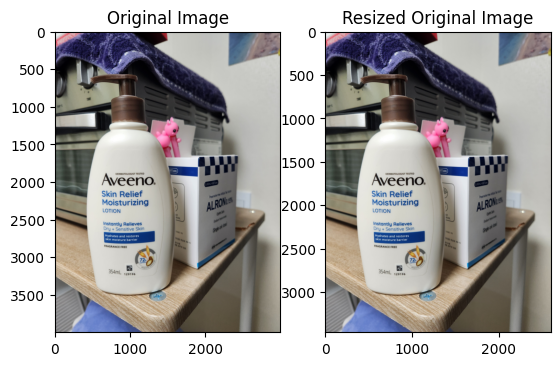

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 이미지 로드
original_image_path = "./data/0.jpg"
extracted_image_path = "./data/5.jpg"

original_image = cv2.imread(original_image_path)
extracted_image = cv2.imread(extracted_image_path)

# resiezed original image 저장경로
resized_image_path = "./data/resized_original_image.jpg"

# SAM 모델 로드
mask_generator = SamAutomaticMaskGenerator(sam)

# 원본 이미지에서 객체 마스크 생성
original_masks = mask_generator.generate(original_image)
extracted_masks = mask_generator.generate(extracted_image)

# 가장 큰 마스크 선택 (로션 통이라고 가정)
original_mask = max(original_masks, key=lambda x: x['area'])['segmentation']
extracted_mask = max(extracted_masks, key=lambda x: x['area'])['segmentation']

# 객체의 픽셀 수 계산
original_pixels = np.sum(original_mask)
extracted_pixels = np.sum(extracted_mask)

# 축소 비율 계산
scaling_factor = np.sqrt(extracted_pixels / original_pixels)

# 원본 이미지 축소
new_size = (int(original_image.shape[1] * scaling_factor), int(original_image.shape[0] * scaling_factor))
resized_original_image = cv2.resize(original_image, new_size)

# 결과 저장
cv2.imwrite(resized_image_path, resized_original_image)

# 결과 확인
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.title("Resized Original Image")
plt.imshow(cv2.cvtColor(resized_original_image, cv2.COLOR_BGR2RGB))
plt.show()


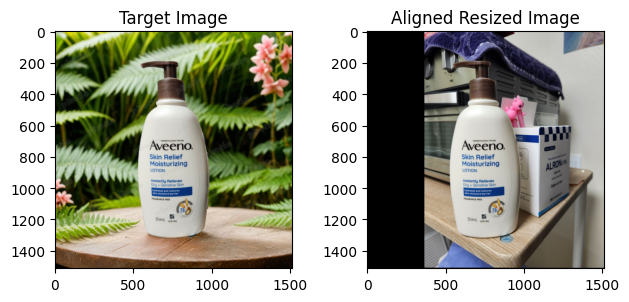

In [6]:
# 이제 원본 이미지랑 축소된 이미지를 가지고, 축소된 이미지를 align 시키면 됨.
# 그 다음에 erosion, delation 등으로 마스크 생성하기.
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 이미지 경로 설정
resized_image_path = "/content/segment-anything/data/resized_original_image.jpg"
target_image_path = "/content/segment-anything/data/4.jpg"

# 이미지 로드
resized_image = cv2.imread(resized_image_path)
target_image = cv2.imread(target_image_path)

# 특징점 추출기 생성 (SIFT 사용)
sift = cv2.SIFT_create()

# 키 포인트와 디스크립터 계산
kp1, des1 = sift.detectAndCompute(resized_image, None)
kp2, des2 = sift.detectAndCompute(target_image, None)

# 매칭기 생성 (FLANN 기반 매칭기)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# 매칭 수행
matches = flann.knnMatch(des1, des2, k=2)

# 좋은 매칭점 선택 (비율 테스트 사용)
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

# 최소 매칭 점 개수 설정
MIN_MATCH_COUNT = 10

if len(good_matches) > MIN_MATCH_COUNT:
    # 좋은 매칭점으로부터 키 포인트 위치 추출
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)

    # 변환 행렬 계산
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # 원근 변환 적용하여 이미지 정렬
    h, w = target_image.shape[:2]
    aligned_image = cv2.warpPerspective(resized_image, M, (w, h))

    # 결과 확인
    plt.subplot(1, 2, 1)
    plt.title("Target Image")
    plt.imshow(cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB))

    plt.subplot(1, 2, 2)
    plt.title("Aligned Resized Image")
    plt.imshow(cv2.cvtColor(aligned_image, cv2.COLOR_BGR2RGB))
    plt.tight_layout()
    plt.show()

    # 정렬된 이미지 저장
    aligned_image_path = "/content/segment-anything/data/aligned_resized_image.jpg"
    cv2.imwrite(aligned_image_path, aligned_image)
else:
    print(f"Not enough matches are found - {len(good_matches)}/{MIN_MATCH_COUNT}")
